In [1]:
import enum
import time
import random
import multiprocessing
from pathlib import Path
import os 

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.auto import tqdm
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = False

random.seed(seed)
torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'
num_workers = multiprocessing.cpu_count()
plt.rcParams['figure.figsize'] = 30, 10

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Thu Sep 14 10:16:09 2023
TorchIO version: 0.18.90


In [2]:
import torch.nn as nn

torch.Size([128, 128, 32])

In [26]:
torch.mean(torch.sum(loss_Ce_torch(output,target)*mask[:,0], dim = (1,2,3))/torch.sum(mask[:,0], dim = (1,2,3)))

tensor(1.4711, grad_fn=<MeanBackward0>)

In [27]:
torch.sum(loss_Ce_torch(output,target)*mask[:,0])/torch.sum(mask[:,0])

tensor(1.4711, grad_fn=<DivBackward0>)

In [77]:
torch.sum(loss_MSE(output,target)[:,0]*mask[:,0],  dim = (1,2,3))/torch.sum(mask[:,0], dim = (1,2,3))

tensor([3.0666, 3.0653, 3.0184, 3.0274, 3.0400, 3.0221, 3.0364, 3.0505, 3.0350,
        3.0497, 3.0512, 3.0561], grad_fn=<DivBackward0>)

In [88]:
torch.sum(torch.sum(loss_MSE(proba,target)[:,1]*mask[:,0],  dim = (1,2,3)))

tensor(334592.2500, grad_fn=<SumBackward0>)

In [85]:
torch.sum(mask[:,0], dim = (1,2,3)).sum()

tensor(756884)

In [73]:
torch.sum(loss_MSE(output,target)[:,1]*mask[:,0],  dim = (1,2,3))

tensor([3.0140, 3.0377, 3.0620, 3.0652, 3.0518, 3.0730, 3.0527, 3.0323, 3.0530,
        3.0567, 3.0325, 3.0205], grad_fn=<DivBackward0>)

In [86]:
(loss_MSE(output,target)[:,1]*mask[:,0]).sum()

tensor(2305419.5000, grad_fn=<SumBackward0>)

In [89]:
torch.mean(torch.sum(loss_MSE(proba,target)[:,1]*mask[:,0], dim = (1,2,3))/torch.sum(mask[:,0], dim = (1,2,3)))

tensor(0.4421, grad_fn=<MeanBackward0>)

In [94]:
from utils_loss import MaskedMSELoss
loss = MaskedMSELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, reduction='mean')
loss(output, target, mask[:,:1])

tensor(0.4421, grad_fn=<DivBackward0>)

In [78]:
torch.sum(loss_MSE(proba,target)[:,1]*mask[:,0])

tensor(334592.2500, grad_fn=<SumBackward0>)

In [67]:
loss = monai.losses.DiceLoss(to_onehot_y=False,softmax=True,include_background=False,batch=False, reduction='none')
loss(output*mask, target*mask).flatten()

tensor([0.8919, 0.8922, 0.8936, 0.8932, 0.8919, 0.8938, 0.8927, 0.8922, 0.8934,
        0.8928, 0.8913, 0.8929], grad_fn=<ReshapeAliasBackward0>)

In [3]:
import torch.nn as nn
import monai
from utils_loss import MSELoss, MaskedCELoss, CELoss, MaskedMSELoss, MaskedDiceCELoss



threshold = 0.9

m = nn.Softmax(dim=1)
output = torch.randn(12, 2, 128,128, 32, requires_grad=True)
proba = m(output)
target = torch.empty(12, 2, 128,128, 32).random_(2).float()

mask=  (proba>threshold).long() + (proba<1-threshold).long() 


#CE

CE_homemade = CELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, reduction='mean')
CE_masked_homemade = MaskedCELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, reduction='mean')

loss_CE = nn.CrossEntropyLoss()
ce = -(torch.sum(((torch.log(proba)*target) + (torch.log(1-proba)*(1-target)))*mask))/mask[:,:1].sum()/2
loss_dice_ce = monai.losses.DiceCELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, lambda_dice=0.0)

loss_Ce_torch = nn.CrossEntropyLoss(reduction= 'none')

print('CE full: ', loss_dice_ce(output,target), loss_CE(output, target), CE_homemade(output,target), torch.mean(loss_Ce_torch(output,target)))
print('CE masked: ', ce, torch.sum(loss_Ce_torch(output,target)*mask[:,0])/torch.sum(mask[:,0]), CE_masked_homemade(output, target, mask[:,:1]))

#Dice
loss = monai.losses.MaskedDiceLoss(to_onehot_y=False,softmax=True,include_background=False,batch=True)
loss_dice= monai.losses.DiceLoss(to_onehot_y=False,softmax=True,include_background=False,batch=True)
dice = loss(output, target, mask=mask[:,:1])
print('Dice: ', dice, loss_dice(output*mask[:,:1], target*mask[:,:1]),loss_dice(output, target))





#MSE
loss_MSE = nn.MSELoss(reduction='none')
mse_sol = torch.sum(loss_MSE(proba,target)[:,1]*mask[:,0])/torch.sum(mask[:,0])

mse = (((proba-target)**2)*mask).sum()/mask.sum()
mse_torch = torch.mean(loss_MSE(proba, target))
test_mse = ((proba*mask[:,:1]-target*mask[:,:1])**2).mean()


MSE_homemade = MSELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, reduction='mean')
MSE_masked_homemade = MaskedMSELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, reduction='mean')



print('MSE: ', MSE_homemade(output, target), mse_torch)
print('MSE masked:', mse, mse_sol, MSE_masked_homemade(output, target, mask[:,:1]))



#Dice CE

dice_ce_sol = dice + torch.sum(loss_Ce_torch(output,target)*mask[:,0])/torch.sum(mask[:,0])


dice_ce_sol = dice + torch.sum(loss_Ce_torch(output,target)*mask[:,0])/torch.sum(mask[:,0])
print('DiceCE masked: ', dice+ce, dice_ce_sol, loss_dice_ce(output*mask[:,:1], target*mask[:,:1]))


print(CE_masked_homemade(output, target, mask[:,:1]) + loss(output, target, mask=mask[:,:1]))


dice_ce_masked_loss_homemade = MaskedDiceCELoss(to_onehot_y=False,softmax=True,include_background=False,batch=True, reduction='mean') 
print(dice_ce_masked_loss_homemade(output, target, mask[:,:1])/2)



CE full:  tensor(0.9032, grad_fn=<AddBackward0>) tensor(0.9032, grad_fn=<DivBackward1>) tensor(0.9032, grad_fn=<MeanBackward0>) tensor(0.9032, grad_fn=<MeanBackward0>)
CE masked:  tensor(1.4712, grad_fn=<DivBackward0>) tensor(1.4711, grad_fn=<DivBackward0>) tensor(1.4711, grad_fn=<MeanBackward0>)
Dice:  tensor(0.8927, grad_fn=<MeanBackward0>) tensor(0.8927, grad_fn=<MeanBackward0>) tensor(0.5001, grad_fn=<MeanBackward0>)
MSE:  tensor(0.3185, grad_fn=<MeanBackward0>) tensor(0.3186, grad_fn=<MeanBackward0>)
torch.Size([12, 1, 128, 128, 32])
MSE masked: tensor(0.4423, grad_fn=<DivBackward0>) tensor(0.4421, grad_fn=<DivBackward0>) tensor(0.4421, grad_fn=<MeanBackward0>)
DiceCE masked:  tensor(2.3638, grad_fn=<AddBackward0>) tensor(2.3637, grad_fn=<AddBackward0>) tensor(0.1770, grad_fn=<AddBackward0>)
tensor(2.3637, grad_fn=<AddBackward0>)
tensor(0.5909, grad_fn=<DivBackward0>)


tensor([0.8919, 0.8922, 0.8936, 0.8932, 0.8919, 0.8938, 0.8927, 0.8922, 0.8934,
        0.8928, 0.8913, 0.8929], grad_fn=<ReshapeAliasBackward0>)

In [177]:
loss_MSE(proba,target)[:,1]

tensor([[[[4.5484e-01, 7.2902e-02, 1.6939e-01,  ..., 1.3408e-01,
           6.0902e-02, 7.9730e-02],
          [5.2162e-01, 1.7572e-01, 3.6363e-01,  ..., 7.2710e-02,
           2.6667e-01, 4.3206e-02],
          [6.1186e-01, 8.6304e-02, 3.4057e-01,  ..., 1.6040e-03,
           1.8240e-01, 1.8206e-02],
          ...,
          [9.7656e-01, 6.8346e-01, 9.0309e-01,  ..., 1.0698e-01,
           4.1379e-02, 2.6800e-01],
          [2.2726e-02, 1.2626e-01, 4.1470e-02,  ..., 6.6933e-01,
           7.5827e-01, 7.9447e-01],
          [5.7774e-01, 6.9398e-02, 2.1112e-01,  ..., 2.0729e-01,
           2.2225e-01, 5.9088e-01]],

         [[8.9230e-01, 5.5419e-01, 5.6956e-01,  ..., 2.1151e-02,
           7.2820e-01, 3.1483e-02],
          [4.3786e-01, 1.4126e-02, 1.9246e-02,  ..., 4.6269e-01,
           2.8028e-01, 5.0885e-01],
          [1.2577e-01, 5.3444e-01, 5.6999e-01,  ..., 9.5054e-02,
           1.4517e-01, 1.9141e-01],
          ...,
          [4.1527e-01, 5.7232e-01, 7.0103e-02,  ..., 7.3046

tensor([[[[4.5484e-01, 7.2902e-02, 3.4626e-01,  ..., 1.3408e-01,
           5.6733e-01, 7.9730e-02],
          [7.7156e-02, 3.3734e-01, 1.5759e-01,  ..., 5.3341e-01,
           2.6667e-01, 4.3206e-02],
          [6.1186e-01, 8.6304e-02, 3.4057e-01,  ..., 1.6040e-03,
           1.8240e-01, 7.4835e-01],
          ...,
          [9.7656e-01, 6.8346e-01, 2.4691e-03,  ..., 1.0698e-01,
           6.3454e-01, 2.6800e-01],
          [7.2122e-01, 1.2626e-01, 6.3419e-01,  ..., 6.6933e-01,
           7.5827e-01, 1.1809e-02],
          [5.7555e-02, 5.4253e-01, 2.1112e-01,  ..., 2.9670e-01,
           2.7939e-01, 5.9088e-01]],

         [[8.9230e-01, 5.5419e-01, 6.0175e-02,  ..., 7.3028e-01,
           2.1508e-02, 3.1483e-02],
          [1.1444e-01, 7.7642e-01, 7.4179e-01,  ..., 4.6269e-01,
           2.8028e-01, 5.0885e-01],
          [4.1650e-01, 7.2331e-02, 6.0036e-02,  ..., 9.5054e-02,
           3.8314e-01, 3.1640e-01],
          ...,
          [1.2644e-01, 5.9285e-02, 5.4056e-01,  ..., 7.3046

loss_MSE(proba,target)

tensor(1.0519, grad_fn=<DivBackward0>)

In [155]:
(loss_Ce_torch(output,target)*mask[:,1]).shape

torch.Size([12, 128, 128, 32])

In [112]:
((input*mask[:,:1]- target*mask[:,:1])**2).mean()

tensor(0.3654, grad_fn=<MeanBackward0>)

In [94]:
input.shape

torch.Size([12, 2, 128, 128, 32])

tensor(1.1141)

In [30]:
x = 

tensor(0.8830, grad_fn=<DivBackward0>)

In [14]:
(mse_masked*mask).sum()/mask.sum()

tensor(0.4420, grad_fn=<DivBackward0>)

In [3]:
input_label = torch.randn(12, 2, 128,128, 32, requires_grad=True)
input_unlabel = torch.randn(12, 2, 128,128, 32, requires_grad=True)


In [78]:
from typing import Any
import warnings



from monai.utils import LossReduction

from monai.networks import one_hot
from torch.nn.modules.loss import _Loss


class MSELoss(_Loss):
    def __init__(self, include_background: bool= True, to_onehot_y: bool = False, softmax: bool = True,
                 reduction = LossReduction.MEAN, sigmoid: bool = False, batch: bool = False,*args: Any, **kwargs: Any) -> None:
        """
        Args follow :py:class:`monai.losses.DiceLoss`.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        
        self.include_background = include_background
        self.to_onehot_y = to_onehot_y
        
        self.softmax = softmax
        self.sigmoid = sigmoid
        self.batch = batch
        
        
        
        
    def forward(self, input: torch.Tensor, target: torch.Tensor ) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD].
            target: the shape should be BNH[WD].
            mask: the shape should B1H[WD] or 11H[WD].
        """
        if self.sigmoid:
            input = torch.sigmoid(input)

        n_pred_ch = input.shape[1]
        if self.softmax:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `softmax=True` ignored.")
            else:
                input = torch.softmax(input, 1)

        if self.to_onehot_y:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")
            else:
                target = one_hot(target, num_classes=n_pred_ch)
                
        if not self.include_background:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `include_background=False` ignored.")
            else:
                # if skipping background, removing first channel
                target = target[:, 1:]
                input = input[:, 1:]
                
        if target.shape != input.shape:
            raise AssertionError(f"ground truth has different shape ({target.shape}) from input ({input.shape})")

        # reducing only spatial dimensions (not batch nor channels)
        reduce_axis: list[int] = torch.arange(2, len(input.shape)).tolist()
        if self.batch:
            # reducing spatial dimensions and batch
            reduce_axis = [0] + reduce_axis

        
        squared_diff = torch.sum((target-input)**2, axis=1)
        
        f = squared_diff

        if self.reduction == LossReduction.MEAN.value:
            f = torch.mean(f)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            f = torch.sum(f)  # sum over the batch and channel dims
        elif self.reduction == LossReduction.NONE.value:
            # If we are not computing voxelwise loss components at least
            # make sure a none reduction maintains a broadcastable shape
            broadcast_shape = list(f.shape[0:2]) + [1] * (len(input.shape) - 2)
            f = f.view(broadcast_shape)
        else:
            raise ValueError(f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].')

        return f
    
class MaskedMSELoss(MSELoss):
    """
    Add an additional `masking` process before `DiceLoss`, accept a binary mask ([0, 1]) indicating a region,
    `input` and `target` will be masked by the region: region with mask `1` will keep the original value,
    region with `0` mask will be converted to `0`. Then feed `input` and `target` to normal `DiceLoss` computation.
    This has the effect of ensuring only the masked region contributes to the loss computation and
    hence gradient calculation.

    """

    def __init__(self, *args: Any, **kwargs: Any) -> None:
        """
        Args follow :py:class:`monai.losses.DiceLoss`.
        """
        super().__init__(*args, **kwargs)
        self.spatial_weighted = monai.losses.MaskedLoss(loss=super().forward)


    def forward(self, input: torch.Tensor, target: torch.Tensor, mask: torch.Tensor ) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD].
            target: the shape should be BNH[WD].
            mask: the shape should B1H[WD] or 11H[WD].
        """
        return self.spatial_weighted(input=input, target=target, mask=mask)  # type: ignore[no-any-return]




In [66]:
from typing import Any
import warnings



from monai.utils import LossReduction

from monai.networks import one_hot
class MaskedMSELoss(_Loss):
    def __init__(self, include_background: bool= True, to_onehot_y: bool = False, softmax: bool = True,
                 reduction = LossReduction.MEAN, sigmoid: bool = False, batch: bool = False,*args: Any, **kwargs: Any) -> None:
        """
        Args follow :py:class:`monai.losses.DiceLoss`.
        """
        super().__init__(reduction=LossReduction(reduction).value)
        
        self.include_background = include_background
        self.to_onehot_y = to_onehot_y
        
        self.softmax = softmax
        self.sigmoid = sigmoid
        self.batch = batch
        
        
        
        
    def forward(self, input: torch.Tensor, target: torch.Tensor, mask: torch.Tensor ) -> torch.Tensor:
        """
        Args:
            input: the shape should be BNH[WD].
            target: the shape should be BNH[WD].
            mask: the shape should B1H[WD] or 11H[WD].
        """
        if self.sigmoid:
            input = torch.sigmoid(input)

        n_pred_ch = input.shape[1]
        if self.softmax:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `softmax=True` ignored.")
            else:
                input = torch.softmax(input, 1)

        if self.to_onehot_y:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `to_onehot_y=True` ignored.")
            else:
                target = one_hot(target, num_classes=n_pred_ch)
                
        if not self.include_background:
            if n_pred_ch == 1:
                warnings.warn("single channel prediction, `include_background=False` ignored.")
            else:
                # if skipping background, removing first channel
                target = target[:, 1:]
                input = input[:, 1:]
                
        if target.shape != input.shape:
            raise AssertionError(f"ground truth has different shape ({target.shape}) from input ({input.shape})")

        # reducing only spatial dimensions (not batch nor channels)
        reduce_axis: list[int] = torch.arange(2, len(input.shape)).tolist()
        if self.batch:
            # reducing spatial dimensions and batch
            reduce_axis = [0] + reduce_axis

        
        squared_diff = (target-input)**2
        
        f = torch.sum(squared_diff * mask , dim=reduce_axis) / (torch.sum(mask, dim =reduce_axis))

        if self.reduction == LossReduction.MEAN.value:
            f = torch.mean(f)  # the batch and channel average
        elif self.reduction == LossReduction.SUM.value:
            f = torch.sum(f)  # sum over the batch and channel dims
        elif self.reduction == LossReduction.NONE.value:
            # If we are not computing voxelwise loss components at least
            # make sure a none reduction maintains a broadcastable shape
            broadcast_shape = list(f.shape[0:2]) + [1] * (len(input.shape) - 2)
            f = f.view(broadcast_shape)
        else:
            raise ValueError(f'Unsupported reduction: {self.reduction}, available options are ["mean", "sum", "none"].')

        return f


In [12]:
noise = torch.clamp(torch.randn_like(input_unlabel)* 0.1, -0.2, 0.2) # Bruit gaussian pas plus gros que 0.2
ema_inputs = input_unlabel + noise

In [13]:
outputs = input_label * 2
with torch.no_grad():
    ema_output = ema_inputs*2


In [17]:
T = 8
volume_batch_r = input_unlabel.repeat(2, 1, 1, 1, 1)
stride = volume_batch_r.shape[0] // 2

In [22]:
preds = torch.zeros([stride * T, 2, 128, 128, 32]).cuda()
for i in range(T//2):
    ema_inputs = volume_batch_r + torch.clamp(torch.randn_like(volume_batch_r) * 0.1, -0.2, 0.2)
    with torch.no_grad():
        preds[2 * stride * i:2 * stride * (i + 1)] = ema_inputs*2

In [25]:
preds = F.softmax(preds, dim=1)
preds = preds.reshape(T, stride, 2, 128, 128, 32)
preds = torch.mean(preds, dim=0)  

uncertainty = -1.0*torch.sum(preds*torch.log(preds + 1e-6), dim=1, keepdim=True) #(batch, 1, 112,112,80)


In [27]:
consistency_weight = 0.1 * ramps.sigmoid_rampup(100//150, 40)


consistency_dist = consistency_criterion(outputs[labeled_bs:], ema_output) #(batch, 2, 112,112,80)
threshold = (0.75+0.25*ramps.sigmoid_rampup(iter_num, max_iterations))*np.log(2)
mask = (uncertainty<threshold).float()
consistency_dist = torch.sum(mask*consistency_dist)/(2*torch.sum(mask)+1e-16)
consistency_loss = consistency_weight * consistency_dist

tensor([[[[[0.6499, 0.6815, 0.5827,  ..., 0.6922, 0.6502, 0.6054],
           [0.6211, 0.5829, 0.6091,  ..., 0.6366, 0.6520, 0.5951],
           [0.6435, 0.6879, 0.6667,  ..., 0.6394, 0.6223, 0.5823],
           ...,
           [0.5835, 0.5880, 0.6218,  ..., 0.6025, 0.6127, 0.5955],
           [0.6376, 0.6862, 0.6176,  ..., 0.6051, 0.6115, 0.5971],
           [0.6057, 0.5913, 0.5889,  ..., 0.6385, 0.5895, 0.5871]],

          [[0.6874, 0.6602, 0.5958,  ..., 0.6037, 0.6035, 0.6403],
           [0.5828, 0.6829, 0.6768,  ..., 0.6013, 0.6910, 0.5859],
           [0.5824, 0.6053, 0.6895,  ..., 0.5927, 0.6931, 0.6021],
           ...,
           [0.5929, 0.6029, 0.6325,  ..., 0.6104, 0.6289, 0.6467],
           [0.5915, 0.6677, 0.5933,  ..., 0.5881, 0.6237, 0.6155],
           [0.6080, 0.6425, 0.6068,  ..., 0.6919, 0.6713, 0.5970]],

          [[0.6140, 0.5840, 0.6587,  ..., 0.6153, 0.6900, 0.6396],
           [0.6306, 0.5860, 0.6878,  ..., 0.6296, 0.5848, 0.6070],
           [0.6120, 0.6391

In [68]:

from monai.losses import DiceLoss
input = torch.rand(B, C, H, W)
target_idx = torch.randint(low=0, high=C - 1, size=(B, H, W)).long()
target = one_hot(target_idx[:, None, ...], num_classes=C)
self = DiceLoss(reduction='none')
loss = self(input, target)
assert np.broadcast_shapes(loss.shape, input.shape) == input.shape

NameError: name 'B' is not defined

# Classic trick to reload library in jupyter: import utils as nash
from importlib import reload
reload(nash)

In [2]:
data_path = 'data/FDG-PET-CT-Lesions_nifti/'

patients = list(np.load(os.path.join(data_path+'positive_patients.npy')))
patients_train, patients_test = train_test_split(patients, test_size = 0.1, random_state=0)

all_paths_train= []
all_paths_test = []
for patient in patients_train:
    examens = os.listdir(os.path.join(data_path,patient))
    for exam in examens:
        all_paths_train.append(os.path.join(os.path.join(data_path,patient), exam))
        
for patient in patients_test:
    examens = os.listdir(os.path.join(data_path,patient))
    for exam in examens:
        all_paths_test.append(os.path.join(os.path.join(data_path,patient), exam))
    

In [3]:
subjects_train = []
for path in all_paths_train:
    subject = tio.Subject(
        ct=tio.ScalarImage(os.path.join(path, 'CTres.nii.gz') ),
        pet=tio.ScalarImage(os.path.join(path, 'SUV.nii.gz') ),
        segmentation=tio.LabelMap(os.path.join(path, 'SEG.nii.gz') ),
    )
    subjects_train.append(subject)
dataset_train = tio.SubjectsDataset(subjects_train)
print('Dataset size:', len(dataset_train), 'subjects')

Dataset size: 489 subjects


In [4]:
subjects_test = []
for path in all_paths_test:
    subject = tio.Subject(
        ct=tio.ScalarImage(os.path.join(path, 'CTres.nii.gz') ),
        pet=tio.ScalarImage(os.path.join(path, 'SUV.nii.gz') ),
        segmentation=tio.LabelMap(os.path.join(path, 'SEG.nii.gz') ),
    )
    subjects_test.append(subject)
dataset_test = tio.SubjectsDataset(subjects_test)
print('Dataset size:', len(dataset_test), 'subjects')

Dataset size: 54 subjects


In [5]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.OneHot(num_classes=2)])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.OneHot(num_classes=2)
    ])

labelled_split_ratio = 0.1
n_train = len(dataset_train)
nl = int(labelled_split_ratio * n_train)
nu = n_train - nl

num_split_subjects = nl, nu
labelled_subjects, unlabelled_subjects = torch.utils.data.random_split(subjects_train, num_split_subjects)

training_labelled_set = tio.SubjectsDataset(
    labelled_subjects, transform=training_transform)

training_unlabelled_set = tio.SubjectsDataset(
    unlabelled_subjects, transform=training_transform)


validation_set = tio.SubjectsDataset(
    subjects_test, transform=validation_transform)

print('Training labelled set:', len(training_labelled_set), 'subjects \t Training unlabelled set:', len(training_unlabelled_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training labelled set: 48 subjects 	 Training unlabelled set: 441 subjects
Validation set: 54 subjects


In [6]:
training_batch_size = 1
validation_batch_size = 2 * training_batch_size

patch_size = (128,128,30)
samples_per_volume = 1
max_queue_length = 1
sampler = tio.data.UniformSampler(patch_size)

patches_training_labelled_set = tio.Queue(
    subjects_dataset=training_labelled_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_training_unlabelled_set = tio.Queue(
    subjects_dataset=training_unlabelled_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=sampler,
    num_workers=num_workers,
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_labelled_loader_patches = torch.utils.data.DataLoader(
    patches_training_labelled_set, batch_size=training_batch_size)

training_unlabelled_loader_patches = torch.utils.data.DataLoader(
    patches_training_unlabelled_set, batch_size=training_batch_size)

validation_loader_patches = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

In [7]:
one_batch = next(iter(training_labelled_loader_patches))

In [8]:
one_batch['segmentation']['data'].shape

NameError: name 'one_batch' is not defined

# Utils

In [9]:
from utils import prepare_batch, get_dice_score, get_dice_loss, get_model_and_optimizer, run_epoch, train

In [10]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

CHANNELS_DIMENSION = 1


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [17]:
import monai
unet = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=2,
    channels=(4, 8, 16),
    strides=(1, 1),
)
unet = unet.to(device)

learning_rate=1e-2
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
loss_function = monai.losses.DiceCELoss(softmax=True)

In [18]:
epoch_losses = []
for batch_idx, batch in enumerate(tqdm(training_labelled_loader_patches)):
    inputs, targets = prepare_batch(batch, device)
    logits = unet(inputs)
    batch_loss = loss_function(logits, targets)
    batch_loss.backward()
    optimizer.step()
    print(batch_loss.item())
    epoch_losses.append(batch_loss.item())

  0%|          | 0/455 [00:00<?, ?it/s]

1.339525818824768
0.8386653661727905
0.6340301632881165
0.5822932720184326
0.5214874148368835
0.5083507895469666
0.5064225196838379
0.5090855360031128
0.50334233045578
0.5215180516242981
0.5010581612586975
0.5000287890434265
0.5000192523002625
0.5914199352264404
0.5000523328781128
0.49980300664901733
0.500038206577301
0.5000171661376953
0.49922457337379456
0.4952628016471863
0.49142563343048096
0.4682731330394745
0.4998035132884979
0.49993032217025757
0.3426441252231598
0.4995730221271515
0.4985935389995575
0.49533960223197937
0.25100409984588623
0.03877878189086914
0.011460274457931519
0.01946359872817993
0.0007806122303009033
0.0005221366882324219
0.0001512467861175537
1.233816146850586e-05
5.602836608886719e-06
2.0772218704223633e-05
0.0
5.960464477539063e-08
3.2782554626464844e-07
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.5039191246032715
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.1045666933059692
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0360136032104492
0.0
0.0
0.0
0.0

In [19]:
epoch_losses = []
for batch_idx, batch in enumerate(tqdm(training_labelled_loader_patches)):
    inputs, targets = prepare_batch(batch, device)
    logits = unet(inputs)
    batch_loss = loss_function(logits, targets)
    batch_loss.backward()
    optimizer.step()
    print(batch_loss.item())
    epoch_losses.append(batch_loss.item())

  0%|          | 0/455 [00:00<?, ?it/s]

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.6248313784599304
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.7487013339996338
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
54.669124603271484
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
8.617166519165039
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.288957595825195
0.0
1.0173509120941162
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
34.76984786987305
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
3.0428013801574707
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
9.69432258605957
0.0
0.0
19.74350929260254
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


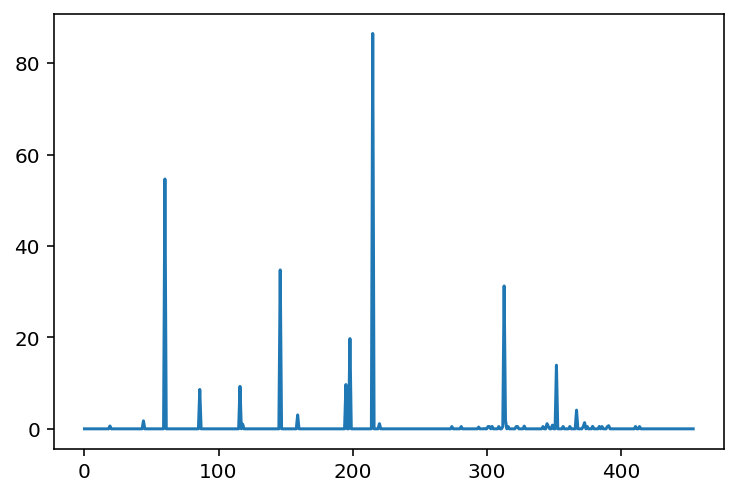

In [20]:
plt.plot(epoch_losses)

In [ ]:
epoch_losses_val = []
for batch_idx, batch in enumerate(tqdm(training_loader_patches)):
    inputs, targets = prepare_batch(one_batch, device)
    logits = unet(inputs)
    batch_losses = get_dice_loss(probabilities, targets)
    batch_loss = batch_losses.mean()
    epoch_losses_val.append(batch_loss.item())

<module 'utils' from '/home/hschmutz/Documents/autoPEt/utils.py'>